<a href="https://colab.research.google.com/github/C-Designer/Codestates_Section_Project/blob/main/Section2/Section2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U pandas-profiling
!pip install category_encoders
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 245kB 8.4MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 604kB 7.7MB/s 
     |████████████████████████████████| 3.1MB 16.4MB/s 
     |████████████████████████████████| 296kB 41.5MB/s 
  Created wheel for phik: filename=phik-0.11.0-cp36-none-any.whl size=599738 sha256=c8f8c428a29b786e62de425a0087618f8d0c9daf4353f776ff8d842a55069e31
  Stored in directory: /root/.cache/pip/wheels/af/54/11/aba77f21075918de02f7964eabfe8c10d5542df9e6ad10b225
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=0ede22facbd773cb40a43e4543d99d148caa77e4c40ec58240a021d5f741a057
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from pdpbox.pdp import pdp_isolate, pdp_plot
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# Dataset : Deep Scapula (견갑골 심부구조)
source : https://www.kaggle.com/iham97/deepscapulassm?select=scapFeaturesUnif_3.csv

#### 견관절부의 주요 질환들을 가장 예측하기 좋은 지표는 CSA(임계 어깨 각도)다

## 스토리텔링
1. 대한의료 정보학회에 데이터 사이언티스트로 근무

2. 견갑골 구조를 분석하여 CSA(임계 어깨 각도)수치를 예측<br>
이후 CSA를 통해 RCI(회전근계 파열)또는 GH joint OA(견관절염) 주의 환자임을 파악해야함

- normal range: 30-35 degrees
- increased CSA: > 35°
  - associated with rotator cuff tears of the shoulder
  - sensitivity 82%; specificity 92%
- decreased CSA: < 30°
  - associated with primary concentric glenohumeral osteoarthritis
  - sensitivity 78%; specificity of 97%

<br>

CSA란? : https://radiopaedia.org/articles/critical-shoulder-angle

CSA와 RCI의 상관관계 분석 : https://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-36162017000400423

견관절부 주요질환 파악에 가장좋은 지표 - CSA : https://bmcmusculoskeletdisord.biomedcentral.com/articles/10.1186/s12891-017-1559-4

In [42]:
df = pd.read_csv('/content/drive/MyDrive/Data Storage/scapFeaturesGauss1_5.csv').iloc[:, 1:12]
df

,CSA,Version,Tilt,Glene Width,Glene Length,Scapula Length,Spine Length,Lat Acromion Angle,Glene Radius,Acromion Shape,Tilt Class
0,35.377494,14.893928,7.700076,24.500691,27.317544,145.339661,134.368393,92.145481,21.871616,1.0,2.0
1,41.238047,9.521284,0.835240,23.780445,35.993161,133.789950,156.821989,97.720930,33.551018,2.0,2.0
2,43.131545,22.434351,25.815892,23.259885,24.567649,123.298976,115.796984,105.685891,20.319127,2.0,2.0
3,25.095480,5.012612,5.640584,29.324090,38.052437,167.421398,143.476972,86.946494,37.621337,2.0,2.0
4,26.290516,5.908531,-1.585274,25.558747,38.942607,163.320756,142.726150,87.366569,38.682884,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,23.108040,-1.986798,-4.001290,21.727007,40.670487,149.754562,138.783717,81.012235,49.572211,2.0,1.0
99996,42.244779,16.983629,10.835220,26.168241,39.389867,177.266484,162.806064,96.959277,25.493845,2.0,2.0
99997,16.448685,3.824296,9.878742,26.307192,33.972964,160.369085,120.473792,61.237730,33.025393,3.0,2.0
99998,25.917182,0.828885,8.055708,28.099462,37.616592,187.296428,136.919227,68.429528,36.212876,2.0,2.0


# EDA

In [43]:
# df.profile_report().to_notebook_iframe()

In [44]:
df.isna().sum()

CSA                   0
Version               0
Tilt                  0
Glene Width           0
Glene Length          0
Scapula Length        0
Spine Length          0
Lat Acromion Angle    0
Glene Radius          0
Acromion Shape        0
Tilt Class            0
dtype: int64

In [50]:
df.describe()

,CSA,Version,Tilt,Glene Width,Glene Length,Scapula Length,Spine Length,Lat Acromion Angle,Glene Radius,Acromion Shape,Tilt Class
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,33.830566,9.561111,5.621756,24.671350,33.834401,154.620458,136.493451,89.009871,30.182140,2.04294,1.810180
std,7.242213,6.379106,6.393997,3.118340,4.342510,19.480935,15.205280,9.776468,8.284924,0.36188,0.392161
min,3.256300,-15.213445,-16.628307,13.024653,18.263390,77.013210,72.560832,19.578528,5.870900,1.00000,1.000000
25%,28.911699,5.138617,1.202943,22.544308,30.828365,141.427860,126.215867,83.052879,24.664689,2.00000,2.000000
50%,33.697017,9.049340,5.325808,24.641797,33.710622,154.596913,136.509038,89.508890,29.233715,2.00000,2.000000
75%,38.600019,13.392462,9.683547,26.753020,36.712499,167.831373,146.707513,95.518573,34.635581,2.00000,2.000000
max,68.581035,49.208023,39.541858,40.308721,55.133939,250.337999,207.331906,128.482970,113.331020,3.00000,2.000000


## Features
- CSA : Critical Shoulder Angle (임계어깨 각도)
- Version : Glenoid Version Angle (날개뼈 내측끝과 견봉돌기를 선으로 연결하여 수직의 선을 그린뒤 관절와 좌우끝과 연결한 선의 각도)
- Tilt : 해당 모형의 날개뼈 tilting 각도
- Glene Width, Length, Radius : Glenoid의 높이, 너비, 반지름 (mm)
- Scapula, Spine Length : 날개뼈의 길이(mm), 척주뼈의 길이(cm)
- Lat Acromion Angle : Lat = Lateral, 측면 견봉각도
- Acromion Shape : 견봉의 형태 (3가지로 분류)
- Tilt Class : 날개뼈가 전방경사 or 후방경사

### Version

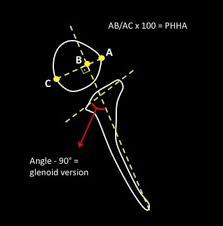

In [ ]:
df['Version'].

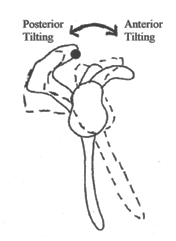

link : http://www.koreascience.kr/article/CFKO200909659873588.pdf

Saha 에 따르면 관절와의 위치는 75%의 환자에서 평균 7도의 후방 경사
(retroversion)가 있고, 25%의 환자에서는 2~10도의 전방 경사가 있다고 하였다

In [49]:
# 클래스의 비율

df['Tilt Class'].value_counts(normalize= True)

2.0    0.81018
1.0    0.18982
Name: Tilt Class, dtype: float64

In [37]:
# tilt class가 1일때 Anterior(전방 경사), 2일때 Posterior(후방 경사)

df[['Tilt', 'Tilt Class']].groupby(['Tilt Class']).mean()

,Tilt
Tilt Class,
1.0,-3.082486
2.0,7.661105


In [47]:
# 전방경사일 경우 견관절염, 후방경사일 경우 회전근개 파열 위험

df[['CSA', 'Tilt Class']].groupby(['Tilt Class']).mean()

,CSA
Tilt Class,
1.0,30.131657
2.0,34.697197
